In [440]:
####Imports and Setup
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import patsy
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
###########################
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
# We are using the BernoulliNB version of Naive Bayes, which assumes predictors are binary encoded.
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

from sklearn.linear_model import LogisticRegressionCV

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import enchant

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [441]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

def update_columns(col_names, label):
    new_names = []
    new_names.append(col_names[0])
    for name in col_names[1:]:
        name = label + name
        new_names.append(name)
    return new_names

def is_ascii(column):
    column_list = []
    for col in column:
        for letter in col:
            if ord(letter) > 128:
                column_list.append(col)
                continue
    return column_list

def del_cols(df):
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        for ch in x:
            if ch not in 'abcdefghijklmnopqrstuvwxyz_0123456789-':
                cols_del.append(x)
                continue
    return cols_del

def del_cols_lyric(df):
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        for ch in x:
            if ch not in 'abcdefghijklmnopqrstuvwxyz_-':
                cols_del.append(x)
                continue
    return cols_del

def del_stopwords(df):
    stop = stopwords.words('english')
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        if x in stop:
            cols_del.append(x)
    return cols_del

In [442]:
conn_addf_metadata = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_track_metadata.db')
conn_lyric = sqlite3.connect('../../Capstone/mxm_dataset.db')

In [443]:
#Combined data set on lyrics and genres (no sub-genres in the data set)
df_lyric_comb = pd.read_csv('../Capestone/df_lyric_genre_metadata.csv')

#Combined data with sub-genres (no lyrics in the data set)
df_tags_comb = pd.read_csv('../Capestone/df_sub_genre_metadata.csv')

###Original datasets
df_songs = pd.read_sql("SELECT * FROM songs", con=conn_addf_metadata)
df_lyric = pd.read_csv('../Capestone/df_lyric_metadata.csv')
df_lyric_original = pd.read_sql("SELECT * FROM lyrics", con=conn_lyric) #key is 'track_id'
df_genre_wide = pd.read_csv('../Capestone/df_genre_wide.csv') #key is 'track_id'
df_genre = pd.read_csv('../../Capstone/genre.csv')
#Original sub-genre/tag datasets
df_mbtag = pd.read_csv('../Capestone/df_term_artist_mbtag_wide.csv') #key is 'artist_id'
df_term = pd.read_csv('../Capestone/df_term_artist_term_wide.csv') #key is 'artist_id'
#Combined sub-genre/tag dataset
df_sub_genre = pd.read_csv('../Capestone/df_sub_genre.csv') #key is 'artist_id'

In [444]:
# ##Cleaning up extra data
df_lyric = df_lyric.drop('Unnamed: 0', axis=1)
df_lyric_comb = df_lyric_comb.drop('Unnamed: 0', axis=1)
df_lyric_original = df_lyric_original.drop('is_test', axis=1)
df_genre_wide = df_genre_wide.drop('Unnamed: 0', axis=1)

In [ ]:
###Create a new lyric dataframe so we can update and manipulate it to remove noise

In [445]:
df_lyric_updated = df_lyric
df_lyric_comb_updated = df_lyric_comb

In [ ]:
##Lyric Data for "popularity" & "Familiarity"

In [446]:
df_lyric_updated.shape

(2350, 5011)

In [447]:
df_lyric_updated['popularity'] = df_lyric_updated['artist_hotttnesss'].map(lambda x: 1 if x >= .6 else 0)
df_lyric_updated['familiarity'] = df_lyric_updated['artist_familiarity'].map(lambda x: 1 if x >= .82 else 0)

In [448]:
pop_cols_del = ['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid', 
              'artist_name', 'duration', 'year_x', 'artist_familiarity', 'artist_hotttnesss', 'familiarity']
fam_cols_del = ['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid', 
              'artist_name', 'duration', 'year_x', 'artist_familiarity','artist_hotttnesss', 'popularity']

In [449]:
###Removing any non ascii characters/features from the dataframe
lyric_columns = del_cols_lyric(df_lyric_updated)

In [450]:
##Drop the columns that don't have ascii characters
df_lyric_updated = df_lyric_updated.drop(lyric_columns, axis=1)

In [451]:
df_lyric_updated.shape

(2350, 4812)

In [452]:
df_lyric_updated.head(1)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,...,zo,zombi,zone,zoo,zu,zum,zur,zwei,popularity,familiarity
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,...,0,0,0,0,0,0,0,0,0,0


###Popularity mdoeling with lyrics

In [453]:
###Look at Popularity first in relation to lyrics
df_lyrics_popularity = df_lyric_updated.drop(pop_cols_del, axis=1)

In [454]:
df_lyrics_popularity.shape

(2350, 4800)

In [455]:
df_lyrics_popularity.head(1)

,a,aaah,aah,aan,ab,abandon,aber,abl,aboard,about,...,zijn,zo,zombi,zone,zoo,zu,zum,zur,zwei,popularity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [456]:
##Find stop words in columns
stop_cols = del_stopwords(df_lyrics_popularity)

In [457]:
##Delete stop words from dataset
df_lyrics_popularity = df_lyrics_popularity.drop(stop_cols, axis=1)

In [458]:
df_lyrics_popularity.shape

(2350, 4684)

In [459]:
###Move the target column to the front of the table
cols = df_lyrics_popularity.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_lyrics_popularity = df_lyrics_popularity[cols]

In [460]:
df_lyrics_popularity.head(1)

,popularity,aaah,aah,aan,ab,abandon,aber,abl,aboard,abov,...,zero,zijn,zo,zombi,zone,zoo,zu,zum,zur,zwei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [461]:
df_test = df_lyrics_popularity.drop('popularity', axis=1)

In [462]:
df_test.head(1)

,aaah,aah,aan,ab,abandon,aber,abl,aboard,abov,abr,...,zero,zijn,zo,zombi,zone,zoo,zu,zum,zur,zwei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
####Remove any columns that don't have any value/counts to the songs

In [463]:
df_test[df_test.columns].sum().sort_values(ascending=True).head(5)

cu          0
sig         0
saben       0
rocknrol    0
coraz       0
dtype: int64

In [464]:
df_test.shape

(2350, 4683)

In [465]:
###Didn't want any lyrics that had a count of less than 5
cols = list(df_test.columns.values)
cols_use, cols_del = [], []
for x in cols:
    if df_test[x].sum() > 0:
        cols_use.append(x)
    else:
        cols_del.append(x)

In [466]:
df_test = df_test.drop(cols_del, axis=1)

In [467]:
df_test.shape

(2350, 4553)

In [468]:
df_test.head()

,aaah,aah,ab,abandon,aber,abl,aboard,abov,abr,absenc,...,za,zeit,zero,zombi,zone,zoo,zu,zum,zur,zwei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
##Check if the word is in the english language

In [469]:
e_dict = enchant.Dict("en_US")

In [470]:
cols_dict = list(df_test.columns.values)
cols_use_dict, cols_del_dict = [], []
for x in cols_dict:
    
    if e_dict.check(x) == True:
        cols_use_dict.append(x)
    else:
        cols_del_dict.append(x)

In [471]:
print len(cols_use_dict)
print len(cols_del_dict)

2455
2098


In [472]:
df_test = df_test.drop(cols_del_dict, axis=1)

In [473]:
df_test.shape

(2350, 2455)

In [474]:
df_test.head(1)

,ab,abandon,aboard,absurd,abyss,accept,ace,acid,across,act,...,yet,yo,yonder,young,younger,youth,z,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
###Take the word count around the average and a standard deviation away from the mean
###Basically, chopping off the ends of the dataset

In [481]:
df_test_columns = df_test[df_test.columns].sum().sort_values(ascending=False)

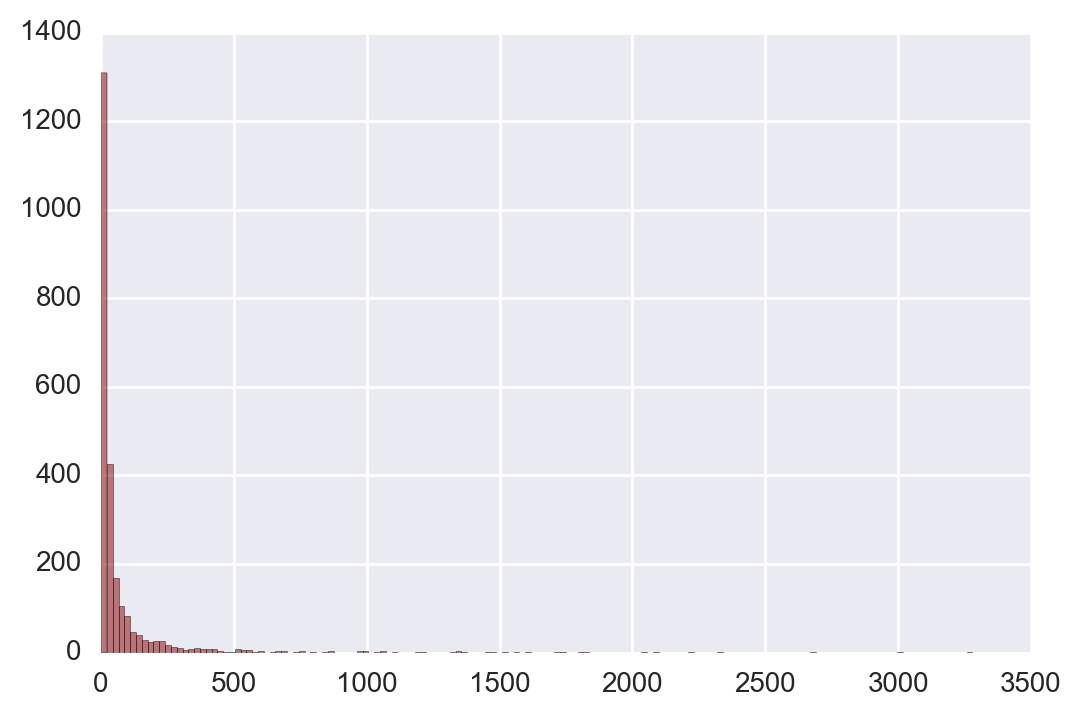

In [487]:
df_test_columns.hist(bins=150, alpha=.5, color='darkred')

In [490]:
df_test_columns.describe()

count    2455.000000
mean       81.340937
std       222.306601
min         1.000000
25%         9.000000
50%        20.000000
75%        57.000000
max      3280.000000
dtype: float64

In [495]:
###Take the middle 50% of the column values (one standard deviation from the mean) - in order
###to pick features that are more unique across the various artists
cols = list(df_test.columns.values)
cols_use, cols_del = [], []
for x in cols:
    if df_test[x].sum() >= 40 and df_test[x].sum() <= 300:
        cols_use.append(x)
    else:
        cols_del.append(x)

In [499]:
print len(cols_use)
print len(cols_del)

646
1809


In [500]:
df_test = df_test.drop(cols_del, axis=1)

In [501]:
df_test.shape

(2350, 646)

In [ ]:
####Look at count and tdidf of the words

In [502]:
from sklearn.feature_extraction.text import TfidfTransformer

In [503]:
tfidf = TfidfTransformer()
count = CountVectorizer()

In [504]:
X_tfidf = tfidf.fit_transform(df_test)

In [505]:
X_tfidf.todense().mean(axis=0)

matrix([[ 0.00401873,  0.00434965,  0.00258089,  0.00580242,  0.00285779,
          0.00344245,  0.0093802 ,  0.00284722,  0.0064281 ,  0.00565563,
          0.00701714,  0.00799403,  0.0074316 ,  0.0061064 ,  0.0029896 ,
          0.00333361,  0.00719812,  0.00845096,  0.00220909,  0.0106694 ,
          0.00531165,  0.00431074,  0.0020603 ,  0.00348992,  0.00225824,
          0.002255  ,  0.00411608,  0.00273854,  0.00158034,  0.00254825,
          0.00910024,  0.00606646,  0.00354834,  0.00537674,  0.00811609,
          0.00398577,  0.00424682,  0.00320724,  0.00348674,  0.00827651,
          0.00327734,  0.01008077,  0.00259196,  0.00387225,  0.00315635,
          0.00482638,  0.00546111,  0.00238961,  0.00790952,  0.00433112,
          0.00546282,  0.00474301,  0.00713156,  0.00348454,  0.00894247,
          0.00597233,  0.01058628,  0.0045916 ,  0.00246983,  0.0023436 ,
          0.00569897,  0.00271683,  0.0029498 ,  0.0070165 ,  0.00250925,
          0.00356232,  0.00227288,  0.

In [506]:
x_df_tfidf = pd.DataFrame(X_tfidf.todense(), columns=df_test.columns)

In [507]:
tf_df_tfidf = pd.DataFrame(x_df_tfidf.mean(), columns=["freq"])

In [508]:
title  =  "Frequency - Top 20: %s, Stopwords: %s" % ("tfidf", "none")

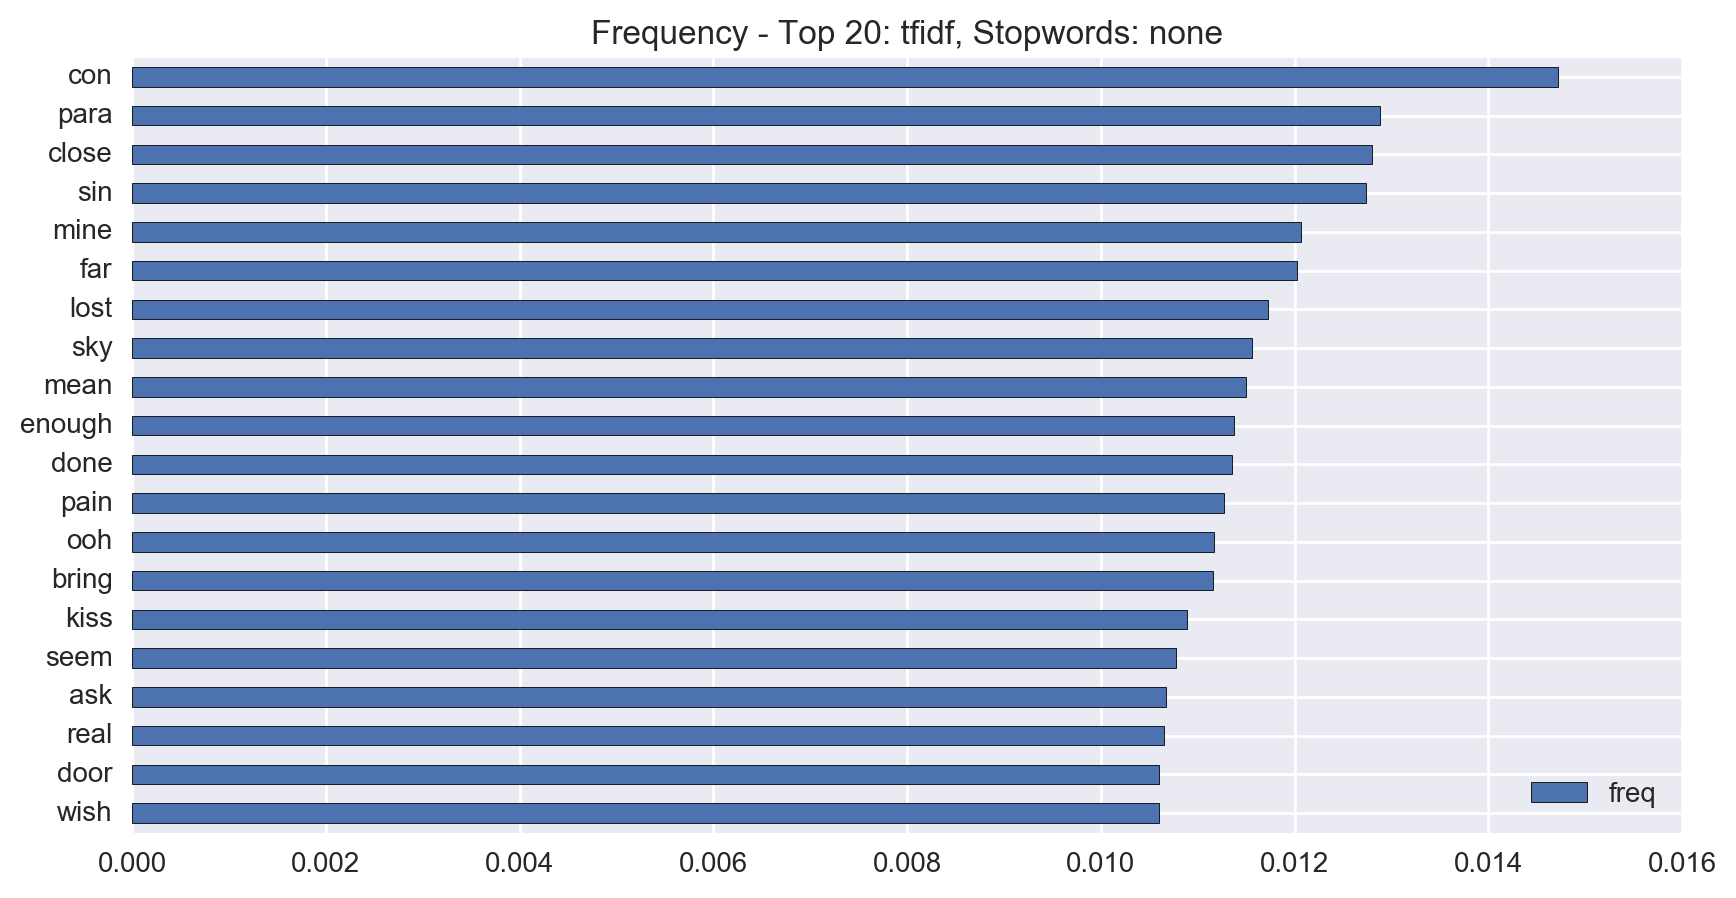

In [509]:
tf_df_tfidf.sort_values("freq").tail(20).plot(kind="barh", title=title, figsize=(10,5))

In [418]:
tf_df_tfidf['freq'].unique()

array([ 0.00064202,  0.00050124,  0.0002648 , ...,  0.00083888,
        0.00099937,  0.00036589])

In [ ]:
###Look at the count of words

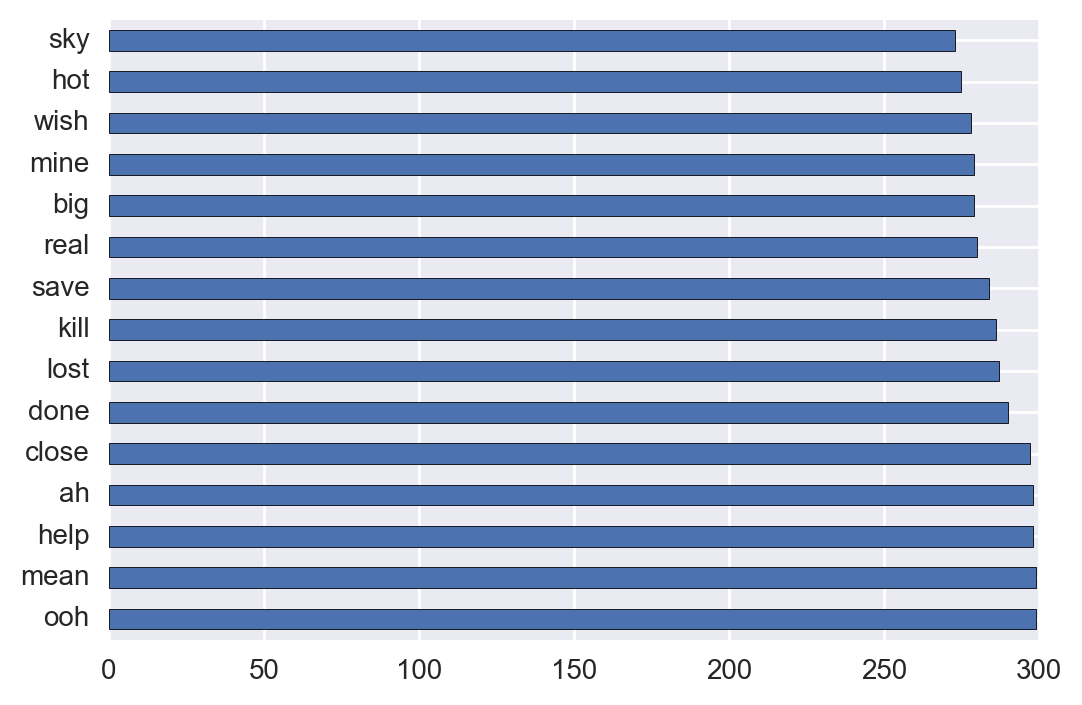

In [511]:
df_test[df_test.columns].sum().sort_values(ascending=False).head(15).plot(kind='barh')

In [ ]:
##Add popularity back into the model

In [512]:
print df_test.shape
print df_lyrics_popularity.shape

(2350, 646)
(2350, 4684)


In [293]:
df_lyrics_popularity.head(1)

,popularity,aaah,aah,aan,ab,abandon,aber,abl,aboard,abov,...,zero,zijn,zo,zombi,zone,zoo,zu,zum,zur,zwei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [513]:
df_test['popularity'] = df_lyrics_popularity['popularity']

In [514]:
df_test.shape

(2350, 647)

In [515]:
df_test.head(1)

,across,act,action,afraid,age,ago,ah,ahead,air,alma,...,wound,wrap,write,ye,yea,yellow,yesterday,yet,young,popularity
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [516]:
###Move the target column to the front of the table
cols = df_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_test = df_test[cols]

In [517]:
df_test.shape

(2350, 647)

In [518]:
df_test.head(1)

,popularity,across,act,action,afraid,age,ago,ah,ahead,air,...,worth,wound,wrap,write,ye,yea,yellow,yesterday,yet,young
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Modeling Lyric data for popularity with logistic regression and KNN (using a gridsearch)

In [540]:
###Start to model the data frame for familiarity based on a logistic regression
y = df_test['popularity'].values
X_tfidf = x_df_tfidf
X_count = df_test.iloc[:,1:]

In [520]:
ss = StandardScaler()
ridge_lr = LogisticRegressionCV(Cs=100, penalty='l2', cv=5)
lasso_lr = LogisticRegressionCV(Cs=100, penalty='l1', solver='liblinear', cv=5)
#lr = LogisticRegression()

In [541]:
Xn_lasso_tfidf = ss.fit_transform(X_tfidf)
Xn_lasso_count = ss.fit_transform(X_count)
Xn_ridge_tfidf = ss.fit_transform(X_tfidf)
Xn_ridge_count = ss.fit_transform(X_count)

In [542]:
X_train_l_tfidf, X_test_l_tfidf, y_train_l_tfidf, y_test_l_tfidf = train_test_split(Xn_lasso_tfidf, y, test_size=0.33)
X_train_l_count, X_test_l_count, y_train_l_count, y_test_l_count = train_test_split(Xn_lasso_count, y, test_size=0.33)
X_train_r_tfidf, X_test_r_tfidf, y_train_r_tfidf, y_test_r_tfidf = train_test_split(Xn_ridge_tfidf, y, test_size=0.33)
X_train_r_count, X_test_r_count, y_train_r_count, y_test_r_count = train_test_split(Xn_ridge_count, y, test_size=0.33)

In [543]:
#Fit the logestic model based on the parameters - for familiarity
lasso_lr.fit(X_train_l_tfidf, y_train_l_tfidf)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [544]:
lasso_lr.fit(X_train_l_count, y_train_l_count)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [525]:
lasso_lr.coef_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [527]:
print 1-np.mean(y_test)
print lasso_lr.score(X_test, y_test)

0.868556701031
0.868556701031


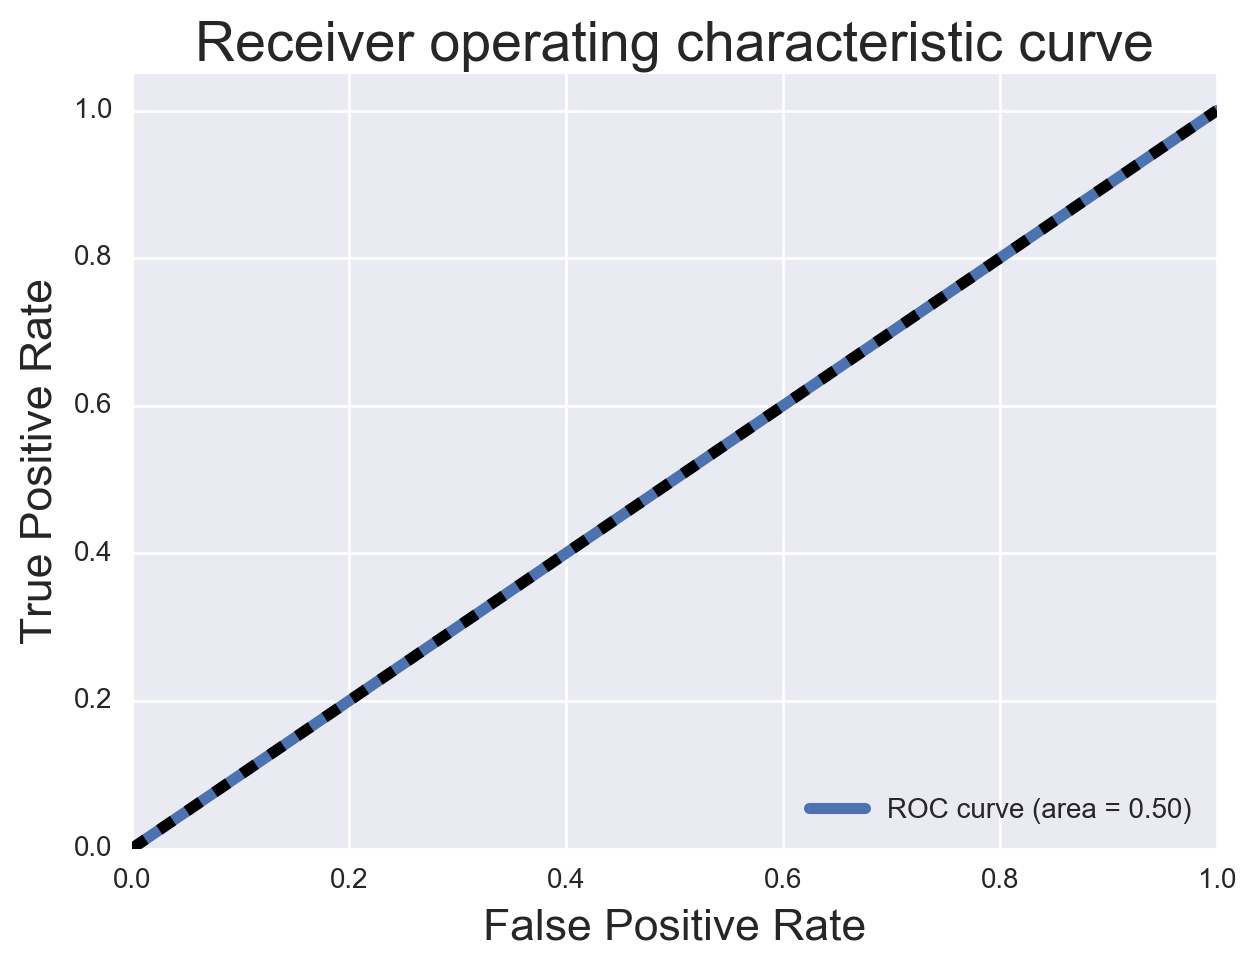

In [530]:
from sklearn.metrics import roc_curve, auc

# Get out the predicted probabilities for the X observation matrix
y_pp = lasso_lr.predict_proba(X_test)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr, tpr, _ = roc_curve(y_test, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[7,5])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [316]:
coefs = pd.DataFrame({'coef':lrcv.coef_[0], 'abs_coef':np.abs(lrcv.coef_[0]),
                      'variable':X.columns})
coefs.sort_values('coef', ascending=False, inplace=True)

In [317]:
coefs.head()

,abs_coef,coef,variable
0,0.0,0.0,ab
1640,0.0,0.0,read
1633,0.0,0.0,rave
1634,0.0,0.0,raven
1635,0.0,0.0,raw


In [319]:
coefs.tail()

,abs_coef,coef,variable
819,0.0,0.0,forest
820,0.0,0.0,forget
821,0.0,0.0,forgiven
822,0.0,0.0,forgot
2454,0.0,0.0,zoo
